# Multilabel Classification

In multi-label classification, each sample can have multiple labels associated with it, as opposed to the traditional single-label classification where each sample can have only one label associated with it. <br/> 

This means that the output of a multi-label classifier is an array of probabilities, one for each label, indicating the probability of the input sample belonging to each label.

# Setting Up

In [1]:
!nvidia-smi

Thu Feb 16 01:56:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    24W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
! pip install -q transformers[sentencepiece] fastbook fastai ohmeow-blurr nbdev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 KB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 97.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.0/79.0 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import torch
from transformers import AutoModelForSequenceClassification, AutoConfig
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *

/usr/local/lib/python3.8/dist-packages/blurr/text/modeling/question_answering.py:31: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  squad_metric = load_metric("squad")


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/NLP_final_project_test/

/content/drive/.shortcut-targets-by-id/1t0CAbX-9zfRBTtu8mMfRCx3_wU_bl-7y/NLP_final_project_test


# Data

In [7]:
df = pd.read_csv("datasets/merged_descriptions.csv")
df.head()

,title,description,genres,genre
0,10-IN-1: ARCADE COLLECTION,"Bring back those retro memories! Test your skill in each of the ten games in this classic arcade collection!\n\nTen minigames filled with retro arts, music, sound effects and fun. One hundred levels filled with a host of enemies to destroy. Dozens of collectable items and power-ups are waiting to help you achieve victory.\n\nBattle against time and enemies to achieve the highest score in each challenge in this 10 in 1: Arcade Collection.\n\nEvery minigame has a new 3D approach to the famous classics. Enjoy hours of fun reliving fond memories of your youth and, if you're too young to rememb...","Genre(s): Miscellaneous, Compilation, Compilation",NaN
1,1001 SPIKES,"Aban Hawkins & the 1,001 Spikes is a 2D platformer where you have 1,001 lives to beat the game.","Genre(s): Action, General, Platformer, Platformer, 2D, 2D",NaN
2,101 DINOPETS 3D,"Over 101 dinos to adopt and love! Teach your dino tricks, enjoy fun games, dress up your dino—all in amazing 3D! What's even more fun than a puppy for a pet? Your very own dinosaur! With 101 DinoPets 3D, you can have a dino friend to care for, teach, play with and love, all in amazing 3D. Choose from over 101 entertaining dinos—or simply adopt them all! Play a game of fetch in the park or teach your dino to dance, jump and fly. Reward your pet with a treat after each trick! Enter your dino into pet shows to earn toys, food, clothing and furniture, then dress up your pet with hats, glasses,...","Genre(s): Simulation, General, General, Virtual, Pet",NaN
3,101 PENGUIN PETS 3D,"Over 101 penguins to adopt and love! Dress up your penguin, teach it tricks, enjoy fun games - all in vivid 3D!\n\nThere's nothing more fun than a pet penguin! Show your penguin how to breakdance and jump, dress it up in hilarious clothes, play silly minigames and more, all in amazing 3D. With 101 Penguin Pets 3D, you can have your very own penguin friend to care for, teach, play with and love!\n\nRomp in the snow, teach your penguin tricks, and enter your pet into dance competitions to earn toys, food, clothing and furniture. Dress up your penguin with hats, glasses and shoes as you zoom ...","Genre(s): Simulation, Miscellaneous, General, General, Virtual, Virtual Life, Pet",NaN
4,101 PONY PETS 3D,"Over 101 ponies to adopt and love! Teach your pony, enjoy fun games, dress up your pony-all in amazing 3D!\n\nWhat's even more fun than a puppy for a pet? Your very own pony! With 101 Pony Pets 3D, you can have a pony friend to care for, teach, play with and love, all in amazing 3D. Choose from over 101 entertaining ponies-or simply adopt them all!\n\nPlay a game of fetch in the park or teach your pony to dance, jump and fly. Reward your pet with a treat after each trick! Enter your pony into pet shows to earn toys, food, clothing and furniture, then dress up your pet with hats, glasses, s...","Genre(s): Simulation, Miscellaneous, Virtual, Virtual Life, Pet",NaN


In [8]:
df.shape

(122857, 4)

In [13]:
df = df.drop_duplicates(subset='description')
df['genres'] = df['genres'].str.replace("Genre\(s\): ", "")
df=df.applymap(str)
df['genres'] = df['genres'].str.split(', ')
df=df.applymap(str)

<ipython-input-13-ea4d6831eb4a>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['genres'] = df['genres'].str.replace("Genre\(s\): ", "")


In [14]:
mask = df.apply(lambda x: x.astype(str).str.contains('N/A', case=False)).any(axis=1)
mask

0         False
1         False
2         False
3         False
4         False
          ...  
122844    False
122845    False
122852    False
122853    False
122856    False
Length: 91273, dtype: bool

In [15]:
df = df[~mask]

In [16]:
df = df.dropna().reset_index(drop=True)
df.shape

(91185, 4)

In [17]:
genres_list = df.genres.to_list()
genre_count = {}
for genres in genres_list:
  genre_list = eval(genres)
  for genre in genre_list:
    if genre in genre_count.keys():
      genre_count[genre] += 1
    else:
      genre_count[genre] = 1
print(f"Number of Genres: {len(genre_count)}")
print(genre_count)

Number of Genres: 180
{'Miscellaneous': 8495, 'Compilation': 1239, 'Action': 35075, 'General': 44692, 'Platformer': 9027, '2D': 8683, 'Simulation': 5471, 'Virtual': 1839, 'Pet': 176, 'Virtual Life': 1035, 'Puzzle': 13479, 'Logic': 1289, 'Flight': 710, 'Shooter': 10513, 'Scrolling': 261, 'Rail': 210, "Shoot-'Em-Up": 4388, 'Combat': 1318, 'Vertical': 1135, "Beat-'Em-Up": 1047, 'Driving': 860, 'Racing': 2264, 'Arcade': 8551, 'Motorcycle': 51, 'Other': 484, 'Automobile': 1728, 'Motocross': 30, 'Fighting': 981, 'Horizontal': 702, 'nan': 1702, 'Board Games': 513, 'Board / Card Game': 1564, 'Adventure': 17290, '3D': 6034, 'First-Person': 6536, 'Matching': 1738, 'Parlor': 195, 'Gambling': 408, 'Role-Playing': 7687, 'Japanese-Style': 1940, 'Vehicle': 880, 'Train': 128, 'Roguelike': 448, 'Action Adventure': 7123, 'Fantasy': 1796, 'Third-Person': 2136, 'Open-World': 1221, 'Sports': 2794, 'Individual': 1418, 'Futuristic': 345, 'Strategy': 11132, 'Turn-Based': 3066, 'Tactics': 1471, 'Nature': 236, 

In [18]:
threshold = int(len(df) * 0.005)
rare_genres = [key for key, value in genre_count.items() if value < threshold]
len(rare_genres), rare_genres[:5]

(107, ['Pet', 'Scrolling', 'Rail', 'Motorcycle', 'Motocross'])

In [19]:
genres_list = df.genres.to_list()
revised_genre_list = []
indices_to_drop = []

for idx, genres in enumerate(genres_list):
  genre_list = eval(genres)
  revised_genres = []

  for genre in genre_list:
    if genre not in rare_genres:
      revised_genres.append(genre)

  if len(revised_genres) == 0:
    indices_to_drop.append(idx)
  else:
    revised_genre_list.append(revised_genres)

df = df.drop(indices_to_drop).reset_index(drop=True)
df.shape

(91184, 4)

In [20]:
df['revised_genres'] = revised_genre_list

In [21]:
df.tail()

,title,description,genres,genre,revised_genres
91179,ZOMBIE VIKINGS,"From the creators of indie smash hit Stick It to The Man! comes a new one to four-player co-op stab-you-in-the-gut-a-thon. Embark on a dead funny adventure with the Zombie Vikings. A putrid posse sent on a mission through the most epic of worlds to retrieve Odins lost eye.\n\nPlay as the most fearsome Vikings ever raised from Norse soil - Gunborg, Seagurd, Hedgy and Caw-kaa. Hack through the gingerbread swamps of Molgaga! Cruise through the intestines of the Midgaard Serpent! Fight giant poultry!\n\nKey Features\n- Co-op story brawler for 1-4 players\n- Single-player and online/offline mul...",['nan'],"Genre(s): Action, Beat-'Em-Up, 2D",[nan]
91180,ZOMBIE WACKERS LITE,"Zombie Wackers is a game all about killing lots of Zombies with your machine gun. You'll need to scale walls and make a few daring jumps here and there too.\n\nThe game was created for a game competition, Ludum Dare 42, and took 25 hours to create.",['nan'],"Genre(s): Action, Platformer, 2D",[nan]
91181,ZOMBO BUSTER RISING,"Shoot zombies from a terrace like a boss! Zombo Buster Rising brings you a nostalgic experience of classic 2D side shooting-defense in the enhanced build!\n\nZombo Buster Rising includes challenging achievements, two AI-Assisted NPCs, three super abilities, various upgrades and Survival mode. Basically it’s the best pick for any fan of casual zombie shooters with only one goal — to slay these undead hordes!",['nan'],"Genre(s): Strategy, Real-Time, Defense",[nan]
91182,ZOO TYCOON,"Let your imagination go bananas with Zoo Tycoon. Build your dream zoo alone or with up to 4 of your friends on Xbox LIVE, choosing from over 100 visually stunning animals and a large, detailed selection of environments. Become a member of the community by uploading your creation to the cloud and working together with other Tycoons to care for and share your animals. With intuitive, easy-to-use controls and Kinect-enabled features that allow your animals to recognize your voice and react to your movements, this zoo simulation will charm animal lovers of all ages.",['nan'],"Genre(s): Tycoon, Strategy, Management, Tycoon, Business / Tycoon",[nan]
91183,ZUMBA FITNESS WORLD PARTY,"Zumba Fitness World Party is a home workout game that helps players burn up to 1,000 calories per hour as you immerse yourself in the movement and music of exotic global destinations such as Brazil, Hawaii and beyond.",['nan'],"Genre(s): Miscellaneous, Exercise / Fitness",[nan]


In [22]:
revised_genres_list = df.revised_genres.to_list()
revised_genre_count = {}
for genres in revised_genres_list:
  genre_list = genres
  for genre in genre_list:
    if genre in revised_genre_count.keys():
      revised_genre_count[genre] += 1
    else:
      revised_genre_count[genre] = 1
print(f"Number of Genres: {len(revised_genre_count)}")
print(revised_genre_count)

Number of Genres: 73
{'Miscellaneous': 8495, 'Compilation': 1239, 'Action': 35075, 'General': 44692, 'Platformer': 9027, '2D': 8683, 'Simulation': 5471, 'Virtual': 1839, 'Virtual Life': 1035, 'Puzzle': 13479, 'Logic': 1289, 'Flight': 710, 'Shooter': 10513, "Shoot-'Em-Up": 4388, 'Combat': 1318, 'Vertical': 1135, "Beat-'Em-Up": 1047, 'Driving': 860, 'Racing': 2264, 'Arcade': 8551, 'Other': 484, 'Automobile': 1728, 'Fighting': 981, 'Horizontal': 702, 'nan': 1702, 'Board Games': 513, 'Board / Card Game': 1564, 'Adventure': 17290, '3D': 6034, 'First-Person': 6536, 'Matching': 1738, 'Role-Playing': 7687, 'Japanese-Style': 1940, 'Vehicle': 880, 'Action Adventure': 7123, 'Fantasy': 1796, 'Third-Person': 2136, 'Open-World': 1221, 'Sports': 2794, 'Individual': 1418, 'Strategy': 11132, 'Turn-Based': 3066, 'Tactics': 1471, 'Career': 862, 'Visual Novel': 3816, 'Team': 1193, 'Edutainment': 1296, 'Hidden Object': 2458, 'Party / Minigame': 1058, 'Sandbox': 534, 'Sci-Fi': 1699, 'Tactical': 712, 'Card B

In [23]:
encode_genre_types = { key: idx for idx, (key, value) in enumerate(revised_genre_count.items())}
with open("genre_types_encoded.json", "w") as fp:
  json.dump(encode_genre_types, fp)

In [24]:
# We need this because for multilabel classification all genres have possibility to be present in the predictions
categorical_genre_list = []
revised_genres_list = df.revised_genres.to_list()

for revised_genres in revised_genres_list:
  categorical_list = [0] * len(encode_genre_types)
  for genre in revised_genres:
    genre_type_index = encode_genre_types[genre] 
    categorical_list[genre_type_index] = 1
  categorical_genre_list.append(categorical_list)

categorical_genre_list[3][:23]

[1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [25]:
df['genre_cat_list'] = categorical_genre_list
df.head()

,title,description,genres,genre,revised_genres,genre_cat_list
0,10-IN-1: ARCADE COLLECTION,"Bring back those retro memories! Test your skill in each of the ten games in this classic arcade collection!\n\nTen minigames filled with retro arts, music, sound effects and fun. One hundred levels filled with a host of enemies to destroy. Dozens of collectable items and power-ups are waiting to help you achieve victory.\n\nBattle against time and enemies to achieve the highest score in each challenge in this 10 in 1: Arcade Collection.\n\nEvery minigame has a new 3D approach to the famous classics. Enjoy hours of fun reliving fond memories of your youth and, if you're too young to rememb...","['Miscellaneous', 'Compilation', 'Compilation']",nan,"[Miscellaneous, Compilation, Compilation]","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1001 SPIKES,"Aban Hawkins & the 1,001 Spikes is a 2D platformer where you have 1,001 lives to beat the game.","['Action', 'General', 'Platformer', 'Platformer', '2D', '2D']",nan,"[Action, General, Platformer, Platformer, 2D, 2D]","[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,101 DINOPETS 3D,"Over 101 dinos to adopt and love! Teach your dino tricks, enjoy fun games, dress up your dino—all in amazing 3D! What's even more fun than a puppy for a pet? Your very own dinosaur! With 101 DinoPets 3D, you can have a dino friend to care for, teach, play with and love, all in amazing 3D. Choose from over 101 entertaining dinos—or simply adopt them all! Play a game of fetch in the park or teach your dino to dance, jump and fly. Reward your pet with a treat after each trick! Enter your dino into pet shows to earn toys, food, clothing and furniture, then dress up your pet with hats, glasses,...","['Simulation', 'General', 'General', 'Virtual', 'Pet']",nan,"[Simulation, General, General, Virtual]","[0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,101 PENGUIN PETS 3D,"Over 101 penguins to adopt and love! Dress up your penguin, teach it tricks, enjoy fun games - all in vivid 3D!\n\nThere's nothing more fun than a pet penguin! Show your penguin how to breakdance and jump, dress it up in hilarious clothes, play silly minigames and more, all in amazing 3D. With 101 Penguin Pets 3D, you can have your very own penguin friend to care for, teach, play with and love!\n\nRomp in the snow, teach your penguin tricks, and enter your pet into dance competitions to earn toys, food, clothing and furniture. Dress up your penguin with hats, glasses and shoes as you zoom ...","['Simulation', 'Miscellaneous', 'General', 'General', 'Virtual', 'Virtual Life', 'Pet']",nan,"[Simulation, Miscellaneous, General, General, Virtual, Virtual Life]","[1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,101 PONY PETS 3D,"Over 101 ponies to adopt and love! Teach your pony, enjoy fun games, dress up your pony-all in amazing 3D!\n\nWhat's even more fun than a puppy for a pet? Your very own pony! With 101 Pony Pets 3D, you can have a pony friend to care for, teach, play with and love, all in amazing 3D. Choose from over 101 entertaining ponies-or simply adopt them all!\n\nPlay a game of fetch in the park or teach your pony to dance, jump and fly. Reward your pet with a treat after each trick! Enter your pony into pet shows to earn toys, food, clothing and furniture, then 

# Dataloaders and Modeling

In [26]:
labels = list(encode_genre_types.keys())

In [27]:
model_name = "bert-base-cased"
model_cls = AutoModelForSequenceClassification
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls=model_cls, config=config)
hf_model.config.problem_type = "multi_label_classification"

In [28]:
blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), MultiCategoryBlock(encoded=True,vocab=labels))
dblock = DataBlock(blocks=blocks, get_x=ColReader('description'), get_y=ColReader('genre_cat_list'), splitter=RandomSplitter(valid_pct=0.1, seed=42))

In [29]:
dls = dblock.dataloaders(df, bs=16)
torch.save(dls, "dataloaders/dls-multilabel-book-classifier.pkl")

In [ ]:
# dls = torch.load("dataloaders/dls-multilabel-book-classifier.pkl")

In [30]:
dls.vocab

['Miscellaneous', 'Compilation', 'Action', 'General', 'Platformer', '2D', 'Simulation', 'Virtual', 'Virtual Life', 'Puzzle', 'Logic', 'Flight', 'Shooter', "Shoot-'Em-Up", 'Combat', 'Vertical', "Beat-'Em-Up", 'Driving', 'Racing', 'Arcade', 'Other', 'Automobile', 'Fighting', 'Horizontal', 'nan', 'Board Games', 'Board / Card Game', 'Adventure', '3D', 'First-Person', 'Matching', 'Role-Playing', 'Japanese-Style', 'Vehicle', 'Action Adventure', 'Fantasy', 'Third-Person', 'Open-World', 'Sports', 'Individual', 'Strategy', 'Turn-Based', 'Tactics', 'Career', 'Visual Novel', 'Team', 'Edutainment', 'Hidden Object', 'Party / Minigame', 'Sandbox', 'Sci-Fi', 'Tactical', 'Card Battle', 'Rhythm', 'Music', 'Real-Time', 'Defense', 'Top-Down', 'Light Gun', 'Action RPG', 'Historic', 'Management', 'Business / Tycoon', 'Survival', 'Civilian', 'Linear', 'Sim', 'Modern', 'Point-and-Click', 'Government', 'Massively Multiplayer', 'Text', 'Massively Multiplayer Online']

In [31]:
dls.show_batch(dataloaders=dls, max_n=4, trunc_at=512)

,text,target
0,"Welcome To The Jungle The "" Wrestling MPire "" is a huge network of promotions from all over the world, which has brought order to the wrestling industry. Featuring over 200 wrestlers, spread across 9 talent pools, it is by far the biggest world ever seen in gaming - or real life for that matter! It's the most diverse world too - featuring 6 unique majors, a wrestling school, a star - studded retirement home, and a resting ground for the deceased. Each of the 6 main federations are truly distinctive - from t","[General, Combat, Sports, Individual]"
1,"Demise of the Faithful is a brand - new Chapter for Dead by Daylight, which includes a new Killer, a Survivor and a Map. Purchasing the Demise of the Faithful DLC will unlock its new Killer, new Survivor, and an exclusive item for the new survivor. Embrace the immense unknown and surrender yourself to the vast inexplicable : that is the oath of the faithful. When surrounded by darkness, they look inward for a beacon of light to follow, trusting it will lead them to safety. But when their light is distorted","[Action Adventure, Survival]"
2,"You have inherited your grandparents farm as they set off to travel the world. Work with Frank at the local construction shop to finish off the final touches on your new home. Aid Frank and Mayor Wilson in building up the town so it may reach it's full potential. In order to expand your home, and build up the nearby town, you're going to need coins. What better way to earn those coins then by running a shop! Explore the islands and caves collecting everything from poop to flowers to sell to the local villag","[Adventure, 3D, Third-Person]"
3,"One of the best action games of all time, “ MEGA MAN X ” comes to iOS with several new options. + Supported OSiPhone 3GS, 4, 4S with iOS 4. 3 onwards / iPod touch 3G onwards? Please note that iPod touch 8GB Model No. A1288 is not supported. ( Model No. can be found on the back of the device ),? This App is not validated on iPad / iPad2 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - + Powered - up features include : 1.? Beauti","[Action, General, Platformer, 2D, Adventure]"


In [ ]:
doc(accuracy_multi)

In [32]:
model = BaseModelWrapper(hf_model)
 
acc_02 = partial(accuracy_multi, thresh=0.2)

learner = Learner(dls, 
                  model,
                  opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
                  loss_func=BCEWithLogitsLossFlat(),
                  metrics=[acc_02],
                  cbs=[BaseModelCallback],
                  splitter=blurr_splitter
                  ).to_fp16()

# Stage - 0

In [ ]:
learner.freeze()

SuggestedLRs(slide=0.0063095735386013985, valley=0.0002754228771664202)

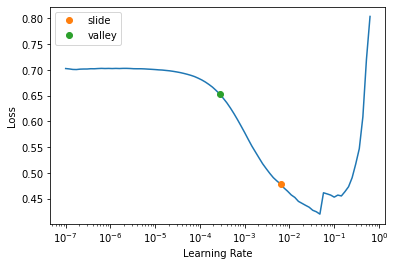

In [ ]:
learner.lr_find(suggest_funcs=[slide, valley])

In [ ]:
learner.fit_one_cycle(3,0.0003)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.104316,0.102469,0.946138,10:38
1,0.093357,0.090926,0.953063,10:42
2,0.091138,0.089203,0.953822,10:46


In [ ]:
learner.fit_one_cycle(2,0.0003)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.091387,0.087513,0.954654,10:40
1,0.087379,0.085280,0.955771,10:36


In [ ]:
learner.fit_one_cycle(2,0.0003)

In [ ]:
learner.save("book-classifier-stage-0")

In [ ]:
learner.export("models/book-classifier-stage-0.pkl")

# Stage - 1

In [33]:
# learner.load("book-classifier-stage-0")

In [34]:
learner.unfreeze()

SuggestedLRs(slide=0.0063095735386013985, valley=3.311311274956097e-06)

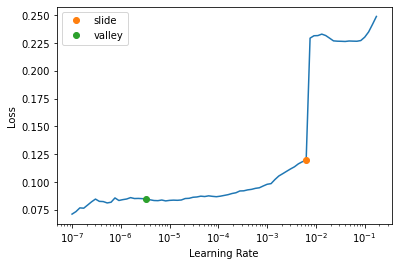

In [35]:
learner.lr_find(suggest_funcs=[slide, valley])

In [36]:
learner.fit_one_cycle(5,slice(0.004, 4.00e-6))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.138695,0.136393,0.954244,15:58
1,0.134477,0.135550,0.954244,15:44
2,0.136131,0.135251,0.954244,15:23
3,0.133667,0.135221,0.954244,15:21
4,0.136765,0.135180,0.954244,15:24


In [37]:
learner.save("book-classifier-stage-1")

Path('models/book-classifier-stage-1.pth')

In [38]:
learner.export("models/book-classifier-stage-1.pkl")